Dataset Links:
1. [Obesity Among Adults by Country (1975-2016)](https://www.kaggle.com/amanarora/obesity-among-adults-by-country-19752016/)
2. [GDP per Person (1901-2011)](https://www.kaggle.com/divyansh22/gdp-per-person-19012011?select=GDP.csv)

### 0. Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

### 1. Obesity Among Adults by Country (1975-2016)

#### Uploading data file

In [2]:
df_obesity = pd.read_csv("datasets/obesity_cleaned.csv", index_col=0)
df_obesity

,Country,Year,Obesity (%),Sex
0,Afghanistan,1975,0.5 [0.2-1.1],Both sexes
1,Afghanistan,1975,0.2 [0.0-0.6],Male
2,Afghanistan,1975,0.8 [0.2-2.0],Female
3,Afghanistan,1976,0.5 [0.2-1.1],Both sexes
4,Afghanistan,1976,0.2 [0.0-0.7],Male
...,...,...,...,...
24565,Zimbabwe,2015,4.5 [2.4-7.6],Male
24566,Zimbabwe,2015,24.8 [18.9-31.3],Female
24567,Zimbabwe,2016,15.5 [12.0-19.2],Both sexes
24568,Zimbabwe,2016,4.7 [2.5-8.0],Male


#### Understanding data type

In [3]:
df_obesity.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24570 entries, 0 to 24569
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Country      24570 non-null  object
 1   Year         24570 non-null  int64 
 2   Obesity (%)  24570 non-null  object
 3   Sex          24570 non-null  object
dtypes: int64(1), object(3)
memory usage: 959.8+ KB


Obesity should appear as float, but it's Dtype object (str)

#### Cleaning data and formatting correctly

In [4]:
df_obesity['Obesity (%)'].value_counts()

Obesity (%)
No data            504
0.4 [0.1-1.0]       55
0.6 [0.2-1.3]       47
0.3 [0.1-0.7]       46
0.3 [0.1-0.8]       46
                  ... 
9.5 [6.7-13.1]       1
4.4 [2.2-7.6]        1
14.1 [9.1-20.3]      1
9.8 [6.9-13.4]       1
4.7 [2.5-8.0]        1
Name: count, Length: 16375, dtype: int64

In [5]:
try:
  df_obesity['Obesity'] = pd.to_numeric(df_obesity['Obesity (%)'].str.split().str[0], errors='coerce')
except:
  df_obesity['Obesity'] = np.nan

df_obesity = df_obesity.dropna()
display(df_obesity['Obesity'].value_counts())

Obesity
0.4     222
0.6     218
0.5     217
0.7     210
0.8     201
       ... 
62.1      1
56.8      1
54.1      1
60.0      1
46.5      1
Name: count, Length: 601, dtype: int64

In [6]:
df_obesity.loc[:, 'Obesity'] = df_obesity['Obesity'].astype(float)
df_obesity.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24066 entries, 0 to 24569
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Country      24066 non-null  object 
 1   Year         24066 non-null  int64  
 2   Obesity (%)  24066 non-null  object 
 3   Sex          24066 non-null  object 
 4   Obesity      24066 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 1.1+ MB


In [7]:
df_obesity.set_index('Year', inplace=True)

#### Exploring data

- What was the average percentage of obesity by sex in the world in 2015?

In [8]:
df = df_obesity[['Sex', 'Obesity']]
df = df[df.index == 2015]
df.groupby('Sex').mean()

,Obesity
Sex,
Both sexes,19.508377
Female,22.899476
Male,15.980628


- Which are the 5 countries with the highest and lowest rate of increase in obesity rates over the observed period?

In [9]:
df_start = df_obesity[df_obesity.index == 1975]
df_start.set_index('Country', inplace=True)

df_end = df_obesity[df_obesity.index == 2016]
df_end.set_index('Country', inplace=True)

In [10]:
df_ev = df_end[df_end['Sex'] == 'Both sexes']['Obesity']  - df_start[df_start['Sex'] == 'Both sexes']['Obesity']
df_ev.sort_values().dropna().head(5)

Country
Viet Nam       2.0
Singapore      3.1
Japan          3.3
Bangladesh     3.4
Timor-Leste    3.6
Name: Obesity, dtype: float64

In [11]:
df_ev.sort_values().dropna().tail(5)

Country
Cook Islands    27.9
Tonga           28.3
Kiribati        30.1
Niue            31.1
Tuvalu          33.7
Name: Obesity, dtype: float64

- Which countries had the highest and lowest percentages of obesity in 2015?

In [12]:
df = df_obesity[df_obesity.index == 2015]
df = df[['Country', 'Obesity']]
df.groupby('Country').mean().sort_values('Obesity', ascending=False)

,Obesity
Country,
Nauru,60.666667
Cook Islands,55.400000
Palau,54.766667
Marshall Islands,52.333333
Tuvalu,50.900000
...,...
India,3.700000
Cambodia,3.600000
Timor-Leste,3.533333


In [13]:
df.groupby('Country').mean().sort_values('Obesity')

,Obesity
Country,
Viet Nam,1.966667
Bangladesh,3.400000
Timor-Leste,3.533333
Cambodia,3.600000
India,3.700000
...,...
Tuvalu,50.900000
Marshall Islands,52.333333
Palau,54.766667


- What is the average percentage difference in obesity between the sexes over the years in Brazil?

<Axes: xlabel='Year'>

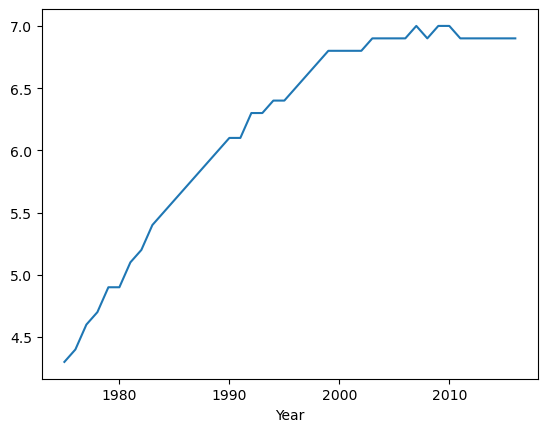

In [14]:
df = df_obesity[df_obesity['Country'] == 'Brazil']
df_diff = df[df['Sex'] == 'Female']['Obesity'] - df[df['Sex'] == 'Male']['Obesity']
df_diff.plot()

- Plot a graph showing the evolution of obesity for both sexes in the world

<Axes: xlabel='Year'>

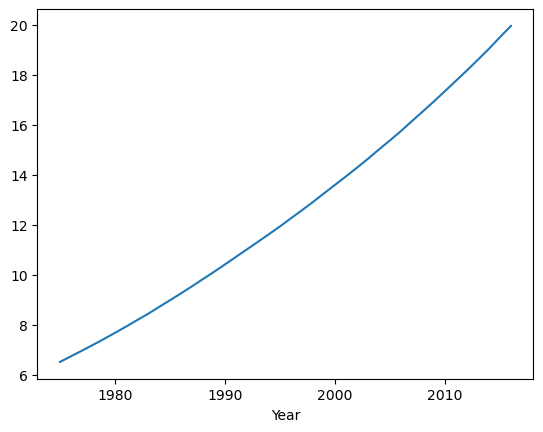

In [15]:
df = df_obesity[df_obesity['Sex'] == 'Both sexes']
df.groupby('Year')['Obesity'].mean().plot()

### 2. GDP per Person (1901-2011)

#### Uploading data file

In [16]:
df_gdp = pd.read_csv("datasets/GDP.csv", thousands=",", decimal=".")
df_gdp

,Country,Region,Year,GDP_pp
0,Afghanistan,"Middle East, North Africa, and Greater Arabia",1/1/1901,613.99
1,Afghanistan,"Middle East, North Africa, and Greater Arabia",1/1/1906,624.04
2,Afghanistan,"Middle East, North Africa, and Greater Arabia",1/1/1911,634.25
3,Afghanistan,"Middle East, North Africa, and Greater Arabia",1/1/1916,647.28
4,Afghanistan,"Middle East, North Africa, and Greater Arabia",1/1/1921,662.40
...,...,...,...,...
4414,Zimbabwe,Sub-Saharan Africa,1/1/1991,782.09
4415,Zimbabwe,Sub-Saharan Africa,1/1/1996,781.50
4416,Zimbabwe,Sub-Saharan Africa,1/1/2001,719.96
4417,Zimbabwe,Sub-Saharan Africa,1/1/2006,520.17


#### Understanding data type

In [17]:
df_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4419 entries, 0 to 4418
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Country   4419 non-null   object 
 1   Region    4419 non-null   object 
 2   Year      4419 non-null   object 
 3    GDP_pp   4419 non-null   float64
dtypes: float64(1), object(3)
memory usage: 138.2+ KB


Year should appear as int, but it's Dtype object (str)

#### Cleaning data and formatting correctly

In [18]:
df_gdp['Year'] = pd.to_datetime(df_gdp['Year']).dt.year
df_gdp

,Country,Region,Year,GDP_pp
0,Afghanistan,"Middle East, North Africa, and Greater Arabia",1901,613.99
1,Afghanistan,"Middle East, North Africa, and Greater Arabia",1906,624.04
2,Afghanistan,"Middle East, North Africa, and Greater Arabia",1911,634.25
3,Afghanistan,"Middle East, North Africa, and Greater Arabia",1916,647.28
4,Afghanistan,"Middle East, North Africa, and Greater Arabia",1921,662.40
...,...,...,...,...
4414,Zimbabwe,Sub-Saharan Africa,1991,782.09
4415,Zimbabwe,Sub-Saharan Africa,1996,781.50
4416,Zimbabwe,Sub-Saharan Africa,2001,719.96
4417,Zimbabwe,Sub-Saharan Africa,2006,520.17


In [19]:
df_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4419 entries, 0 to 4418
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Country   4419 non-null   object 
 1   Region    4419 non-null   object 
 2   Year      4419 non-null   int32  
 3    GDP_pp   4419 non-null   float64
dtypes: float64(1), int32(1), object(2)
memory usage: 121.0+ KB


#### Exploring data

- What is the first value recorded for each country?

In [20]:
df_gdp.sort_values(['Year', 'Country']).drop_duplicates(subset='Country')[['Country', ' GDP_pp ']]

,Country,GDP_pp
0,Afghanistan,613.99
23,Albania,1062.01
46,Algeria,1807.76
69,Andorra,3352.50
92,Angola,525.76
...,...,...
4327,Vietnam,572.96
4350,"Yemen, Rep.",729.39
4373,Zambia,532.38
4396,Zimbabwe,385.69


- Name the regions with the highest growth in GDP per capita in the last century.

In [21]:
df_gdp[df_gdp['Year'] < 2000].max()

Country               Zimbabwe
Region      Sub-Saharan Africa
Year                      1996
 GDP_pp               118681.3
dtype: object

In [22]:
df_start = df_gdp[df_gdp['Year'] == 1901]
df_end = df_gdp[df_gdp['Year'] == 1996]

In [23]:
(((df_end.groupby('Region')[' GDP_pp '].mean() / df_start.groupby('Region')[' GDP_pp '].mean()) - 1)*100).sort_values()

Region
Sub-Saharan Africa                               248.633780
South America                                    312.123735
Australia and Oceania                            396.075383
Central America and the Caribbean                406.426789
North America                                    589.760175
Europe                                           594.046167
Asia                                             711.761516
Middle East, North Africa, and Greater Arabia    857.215950
Name:  GDP_pp , dtype: float64

- Fill in the missing years in each country with an estimate, based on the difference between the next record and the previous one.

In [24]:
df_gdp

,Country,Region,Year,GDP_pp
0,Afghanistan,"Middle East, North Africa, and Greater Arabia",1901,613.99
1,Afghanistan,"Middle East, North Africa, and Greater Arabia",1906,624.04
2,Afghanistan,"Middle East, North Africa, and Greater Arabia",1911,634.25
3,Afghanistan,"Middle East, North Africa, and Greater Arabia",1916,647.28
4,Afghanistan,"Middle East, North Africa, and Greater Arabia",1921,662.40
...,...,...,...,...
4414,Zimbabwe,Sub-Saharan Africa,1991,782.09
4415,Zimbabwe,Sub-Saharan Africa,1996,781.50
4416,Zimbabwe,Sub-Saharan Africa,2001,719.96
4417,Zimbabwe,Sub-Saharan Africa,2006,520.17


In [25]:
arr_year = np.arange(df_gdp['Year'].min(), df_gdp['Year'].max())
df_all_years = pd.DataFrame(arr_year, columns=['Year'])
df_all_years.index = df_all_years['Year']
df_all_years

,Year
Year,
1901,1901
1902,1902
1903,1903
1904,1904
1905,1905
...,...
2006,2006
2007,2007
2008,2008


In [26]:
df_years_off = ~df_all_years['Year'].isin(df_gdp['Year'])
df_years_off

Year
1901    False
1902     True
1903     True
1904     True
1905     True
        ...  
2006    False
2007     True
2008     True
2009     True
2010     True
Name: Year, Length: 110, dtype: bool

In [27]:
df_years_off = df_all_years.loc[df_years_off].index
df_years_off

Index([1902, 1903, 1904, 1905, 1907, 1908, 1909, 1910, 1912, 1913, 1914, 1915,
       1917, 1918, 1919, 1920, 1922, 1923, 1924, 1925, 1927, 1928, 1929, 1930,
       1932, 1933, 1934, 1935, 1937, 1938, 1939, 1940, 1942, 1943, 1944, 1945,
       1947, 1948, 1949, 1950, 1952, 1953, 1954, 1955, 1957, 1958, 1959, 1960,
       1962, 1963, 1964, 1965, 1967, 1968, 1969, 1970, 1972, 1973, 1974, 1975,
       1977, 1978, 1979, 1980, 1982, 1983, 1984, 1985, 1987, 1988, 1989, 1990,
       1992, 1993, 1994, 1995, 1997, 1998, 1999, 2000, 2002, 2003, 2004, 2005,
       2007, 2008, 2009, 2010],
      dtype='int32', name='Year')

In [28]:
df_gdp = df_gdp.sort_values(['Country', 'Year'])

df_gdp['Delta_gdp'] = df_gdp[' GDP_pp '] - df_gdp[' GDP_pp '].shift(1)
df_gdp['Delta_year'] = df_gdp['Year'] - df_gdp['Year'].shift(1)

df_gdp['gdp_year'] = (df_gdp['Delta_gdp']/df_gdp['Delta_year']).shift(-1)

df_gdp

,Country,Region,Year,GDP_pp,Delta_gdp,Delta_year,gdp_year
0,Afghanistan,"Middle East, North Africa, and Greater Arabia",1901,613.99,NaN,NaN,2.010
1,Afghanistan,"Middle East, North Africa, and Greater Arabia",1906,624.04,10.05,5.0,2.042
2,Afghanistan,"Middle East, North Africa, and Greater Arabia",1911,634.25,10.21,5.0,2.606
3,Afghanistan,"Middle East, North Africa, and Greater Arabia",1916,647.28,13.03,5.0,3.024
4,Afghanistan,"Middle East, North Africa, and Greater Arabia",1921,662.40,15.12,5.0,3.094
...,...,...,...,...,...,...,...
4414,Zimbabwe,Sub-Saharan Africa,1991,782.09,39.79,5.0,-0.118
4415,Zimbabwe,Sub-Saharan Africa,1996,781.50,-0.59,5.0,-12.308
4416,Zimbabwe,Sub-Saharan Africa,2001,719.96,-61.54,5.0,-39.958
4417,Zimbabwe,Sub-Saharan Africa,2006,520.17,-199.79,5.0,1.232


In [29]:
df_gdp['next_year'] = df_gdp['Year'].shift(-1)
del df_gdp['Delta_gdp'], df_gdp['Delta_year']

df_gdp

,Country,Region,Year,GDP_pp,gdp_year,next_year
0,Afghanistan,"Middle East, North Africa, and Greater Arabia",1901,613.99,2.010,1906.0
1,Afghanistan,"Middle East, North Africa, and Greater Arabia",1906,624.04,2.042,1911.0
2,Afghanistan,"Middle East, North Africa, and Greater Arabia",1911,634.25,2.606,1916.0
3,Afghanistan,"Middle East, North Africa, and Greater Arabia",1916,647.28,3.024,1921.0
4,Afghanistan,"Middle East, North Africa, and Greater Arabia",1921,662.40,3.094,1926.0
...,...,...,...,...,...,...
4414,Zimbabwe,Sub-Saharan Africa,1991,782.09,-0.118,1996.0
4415,Zimbabwe,Sub-Saharan Africa,1996,781.50,-12.308,2001.0
4416,Zimbabwe,Sub-Saharan Africa,2001,719.96,-39.958,2006.0
4417,Zimbabwe,Sub-Saharan Africa,2006,520.17,1.232,2011.0


In [30]:
df_new_data = pd.DataFrame()

for idx, row in df_gdp.iterrows():
    if row['Year'] == 2011:
        continue

    years_to_add = df_years_off[(df_years_off > row['Year']) & (df_years_off < row['next_year'])]
    
    for new_year in years_to_add:
        add_row = row.copy()
        add_row[' GDP_pp '] = (new_year - add_row['Year']) * add_row['gdp_year'] + add_row[' GDP_pp ']
        add_row['Year'] = new_year
        add_row['kind'] = 'estimated'
        df_new_data = pd.concat([df_new_data, add_row.to_frame().transpose()])

df_new_data

,Country,Region,Year,GDP_pp,gdp_year,next_year,kind
0,Afghanistan,"Middle East, North Africa, and Greater Arabia",1902,616.0,2.01,1906.0,estimated
0,Afghanistan,"Middle East, North Africa, and Greater Arabia",1903,618.01,2.01,1906.0,estimated
0,Afghanistan,"Middle East, North Africa, and Greater Arabia",1904,620.02,2.01,1906.0,estimated
0,Afghanistan,"Middle East, North Africa, and Greater Arabia",1905,622.03,2.01,1906.0,estimated
1,Afghanistan,"Middle East, North Africa, and Greater Arabia",1907,626.082,2.042,1911.0,estimated
...,...,...,...,...,...,...,...
4416,Zimbabwe,Sub-Saharan Africa,2005,560.128,-39.958,2006.0,estimated
4417,Zimbabwe,Sub-Saharan Africa,2007,521.402,1.232,2011.0,estimated
4417,Zimbabwe,Sub-Saharan Africa,2008,522.634,1.232,2011.0,estimated
4417,Zimbabwe,Sub-Saharan Africa,2009,523.866,1.232,2011.0,estimated


In [31]:
df_gdp = pd.concat([df_gdp, df_new_data])
df_gdp.sort_values(['Country', 'Year'], inplace=True)
df_gdp.index = df_gdp['Year']
df_gdp['kind'].fillna('real', inplace=True)
df_gdp

,Country,Region,Year,GDP_pp,gdp_year,next_year,kind
Year,,,,,,,
1901,Afghanistan,"Middle East, North Africa, and Greater Arabia",1901,613.99,2.01,1906.0,real
1902,Afghanistan,"Middle East, North Africa, and Greater Arabia",1902,616.0,2.01,1906.0,estimated
1903,Afghanistan,"Middle East, North Africa, and Greater Arabia",1903,618.01,2.01,1906.0,estimated
1904,Afghanistan,"Middle East, North Africa, and Greater Arabia",1904,620.02,2.01,1906.0,estimated
1905,Afghanistan,"Middle East, North Africa, and Greater Arabia",1905,622.03,2.01,1906.0,estimated
...,...,...,...,...,...,...,...
2007,Zimbabwe,Sub-Saharan Africa,2007,521.402,1.232,2011.0,estimated
2008,Zimbabwe,Sub-Saharan Africa,2008,522.634,1.232,2011.0,estimated
2009,Zimbabwe,Sub-Saharan Africa,2009,523.866,1.232,2011.0,estimated


- Checking if the estimate is consistent

<Axes: xlabel='Year', ylabel=' GDP_pp '>

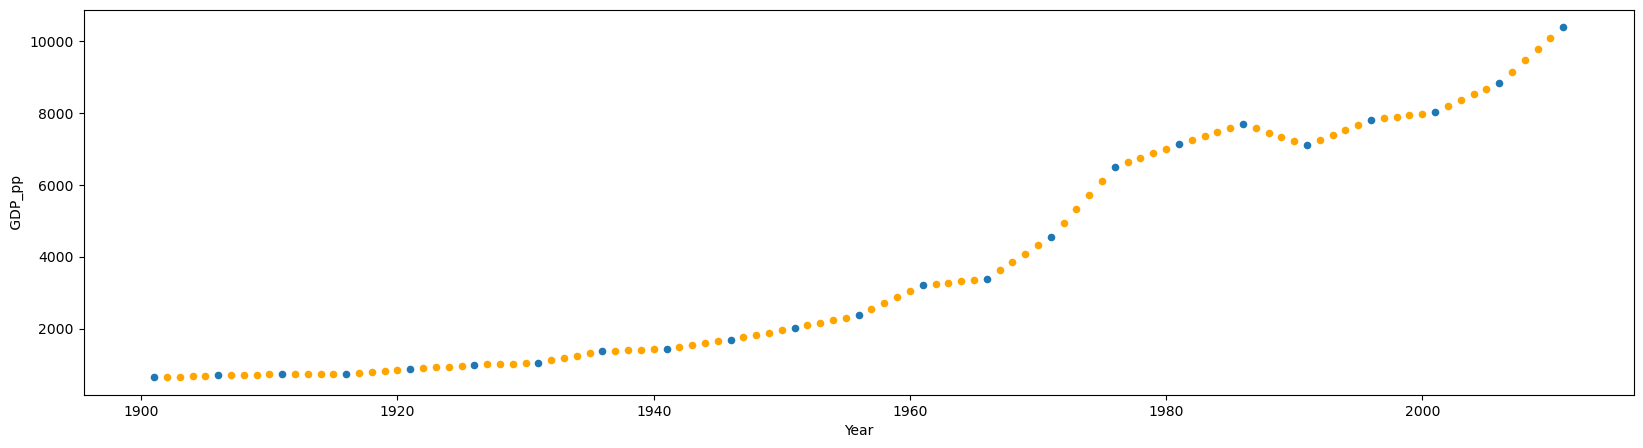

In [32]:
fig, ax = plt.subplots(figsize=(20, 5))

country = 'Brazil'
df_gdp[(df_gdp['kind'] == 'real') & (df_gdp['Country'] == country)].plot(kind='scatter', y=' GDP_pp ', x='Year', ax=ax)
df_gdp[(df_gdp['kind'] == 'estimated') & (df_gdp['Country'] == country)].plot(kind='scatter', y=' GDP_pp ', x='Year', ax=ax, color = 'orange')

### 3. Comparing Both Datasets

- Create a map of GDP or obesity in the world over the years

In [33]:
df_gdp['Year'] = df_gdp['Year'].astype(int)
df_gdp[' GDP_pp '] = df_gdp[' GDP_pp '].astype(float)

In [34]:
df = px.data.gapminder()
df

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
0,Afghanistan,Asia,1952,28.801,8425333,779.445314,AFG,4
1,Afghanistan,Asia,1957,30.332,9240934,820.853030,AFG,4
2,Afghanistan,Asia,1962,31.997,10267083,853.100710,AFG,4
3,Afghanistan,Asia,1967,34.020,11537966,836.197138,AFG,4
4,Afghanistan,Asia,1972,36.088,13079460,739.981106,AFG,4
...,...,...,...,...,...,...,...,...
1699,Zimbabwe,Africa,1987,62.351,9216418,706.157306,ZWE,716
1700,Zimbabwe,Africa,1992,60.377,10704340,693.420786,ZWE,716
1701,Zimbabwe,Africa,1997,46.809,11404948,792.449960,ZWE,716
1702,Zimbabwe,Africa,2002,39.989,11926563,672.038623,ZWE,716


In [35]:
dict_iso_alpha = df.set_index('country').to_dict()['iso_alpha']

In [36]:
dict_num = {j: i for i, j in enumerate(df_gdp['Country'].unique())}

In [37]:
df_gdp['iso_alpha'] = df_gdp['Country'].map(dict_iso_alpha)
df_gdp['iso_num'] = df_gdp['Country'].map(dict_num)
df_gdp

,Country,Region,Year,GDP_pp,gdp_year,next_year,kind,iso_alpha,iso_num
Year,,,,,,,,,
1901,Afghanistan,"Middle East, North Africa, and Greater Arabia",1901,613.990,2.01,1906.0,real,AFG,0
1902,Afghanistan,"Middle East, North Africa, and Greater Arabia",1902,616.000,2.01,1906.0,estimated,AFG,0
1903,Afghanistan,"Middle East, North Africa, and Greater Arabia",1903,618.010,2.01,1906.0,estimated,AFG,0
1904,Afghanistan,"Middle East, North Africa, and Greater Arabia",1904,620.020,2.01,1906.0,estimated,AFG,0
1905,Afghanistan,"Middle East, North Africa, and Greater Arabia",1905,622.030,2.01,1906.0,estimated,AFG,0
...,...,...,...,...,...,...,...,...,...
2007,Zimbabwe,Sub-Saharan Africa,2007,521.402,1.232,2011.0,estimated,ZWE,192
2008,Zimbabwe,Sub-Saharan Africa,2008,522.634,1.232,2011.0,estimated,ZWE,192
2009,Zimbabwe,Sub-Saharan Africa,2009,523.866,1.232,2011.0,estimated,ZWE,192


In [38]:
fig = px.choropleth(
    df_gdp[df_gdp['kind'] == 'real'].reset_index(drop=True), 
    locations='iso_alpha', 
    color=' GDP_pp ', 
    hover_name='Country', 
    animation_frame='Year'
)
fig.update_layout(height=600)
fig.show()

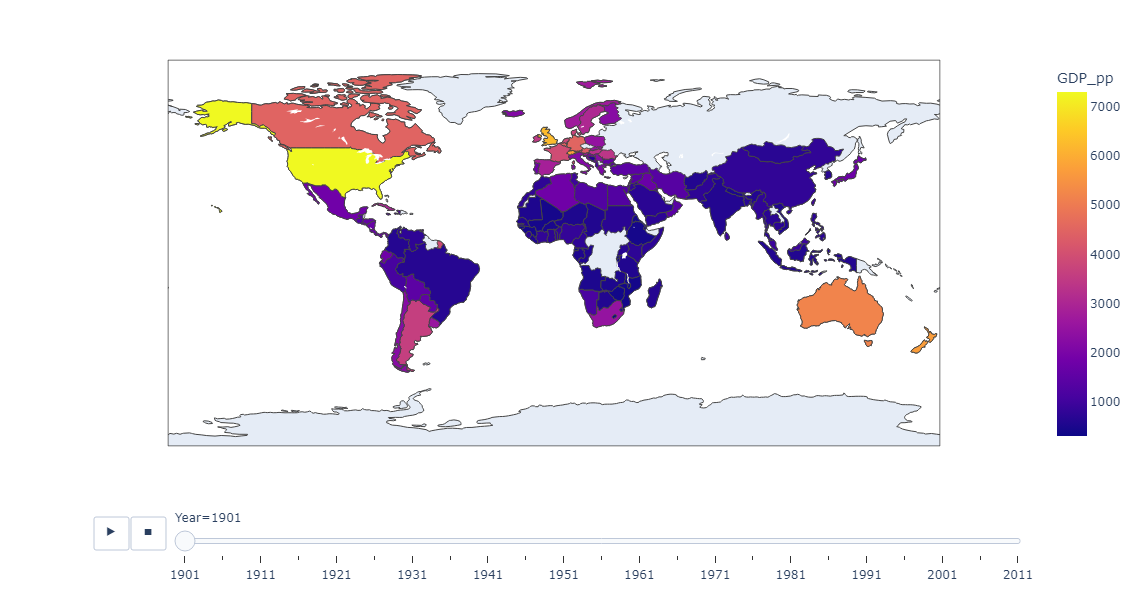

- Is there a relationship between obesity levels and GDP per capita?

In [39]:
df_obesity = df_obesity.reset_index()
df_obesity['country-year'] = df_obesity['Country'].str.cat(df_obesity['Year'].astype(str), sep='-')

dict_obesity_year = df_obesity.set_index('country-year')['Obesity'].to_dict()

In [40]:
df_gdp['country-year'] = df_gdp['Country'] + '-' + df_gdp['Year'].apply(lambda x: str(int(x))).values
dict_gdp_year = df_gdp.set_index('country-year').to_dict()[' GDP_pp ']

In [41]:
df_gdp['obesity'] = df_gdp['country-year'].map(dict_obesity_year)
df_gdp

,Country,Region,Year,GDP_pp,gdp_year,next_year,kind,iso_alpha,iso_num,country-year,obesity
Year,,,,,,,,,,,
1901,Afghanistan,"Middle East, North Africa, and Greater Arabia",1901,613.990,2.01,1906.0,real,AFG,0,Afghanistan-1901,NaN
1902,Afghanistan,"Middle East, North Africa, and Greater Arabia",1902,616.000,2.01,1906.0,estimated,AFG,0,Afghanistan-1902,NaN
1903,Afghanistan,"Middle East, North Africa, and Greater Arabia",1903,618.010,2.01,1906.0,estimated,AFG,0,Afghanistan-1903,NaN
1904,Afghanistan,"Middle East, North Africa, and Greater Arabia",1904,620.020,2.01,1906.0,estimated,AFG,0,Afghanistan-1904,NaN
1905,Afghanistan,"Middle East, North Africa, and Greater Arabia",1905,622.030,2.01,1906.0,estimated,AFG,0,Afghanistan-1905,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2007,Zimbabwe,Sub-Saharan Africa,2007,521.402,1.232,2011.0,estimated,ZWE,192,Zimbabwe-2007,21.3
2008,Zimbabwe,Sub-Saharan Africa,2008,522.634,1.232,2011.0,estimated,ZWE,192,Zimbabwe-2008,21.7
2009,Zimbabwe,Sub-Saharan Africa,2009,523.866,1.232,2011.0,estimated,ZWE,192,Zimbabwe-2009,22.2


In [42]:
df_gdp_clean = df_gdp.dropna()
df_gdp_clean

,Country,Region,Year,GDP_pp,gdp_year,next_year,kind,iso_alpha,iso_num,country-year,obesity
Year,,,,,,,,,,,
1975,Afghanistan,"Middle East, North Africa, and Greater Arabia",1975,847.692,18.498,1976.0,estimated,AFG,0,Afghanistan-1975,0.8
1976,Afghanistan,"Middle East, North Africa, and Greater Arabia",1976,866.190,6.134,1981.0,real,AFG,0,Afghanistan-1976,0.8
1977,Afghanistan,"Middle East, North Africa, and Greater Arabia",1977,872.324,6.134,1981.0,estimated,AFG,0,Afghanistan-1977,0.9
1978,Afghanistan,"Middle East, North Africa, and Greater Arabia",1978,878.458,6.134,1981.0,estimated,AFG,0,Afghanistan-1978,0.9
1979,Afghanistan,"Middle East, North Africa, and Greater Arabia",1979,884.592,6.134,1981.0,estimated,AFG,0,Afghanistan-1979,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2006,Zimbabwe,Sub-Saharan Africa,2006,520.170,1.232,2011.0,real,ZWE,192,Zimbabwe-2006,20.9
2007,Zimbabwe,Sub-Saharan Africa,2007,521.402,1.232,2011.0,estimated,ZWE,192,Zimbabwe-2007,21.3
2008,Zimbabwe,Sub-Saharan Africa,2008,522.634,1.232,2011.0,estimated,ZWE,192,Zimbabwe-2008,21.7


In [43]:
df_gdp_clean.reset_index(drop=True).groupby('Year')[['obesity', ' GDP_pp ']].mean().corr()

,obesity,GDP_pp
obesity,1.000000,0.969378
GDP_pp,0.969378,1.000000


The correlation is high, 96,94%